# Vertex AI Agent Builder Ranking API

**Why Ranking Matters:**

* Accuracy: Embedding methods (bi-encoders) excel at speed and scalability by independently encoding the query and candidate chunks. However, cross-encoders, which jointly encode the query and chunk, offer superior accuracy in assessing relevance.
* Efficiency: While cross-encoders are more accurate, they can be computationally expensive for large datasets.

## imports

In [1]:
import os, shutil, json

import numpy as np
import matplotlib.pyplot as plt

from google.cloud import aiplatform
import vertexai.generative_models
import vertexai.language_models
import google.cloud.discoveryengine_v1 as discoveryengine

print(f"Ai Platform SDK version = {aiplatform.__version__}")
print(f"Discovery Engine API version = {discoveryengine.__version__}")

Ai Platform SDK version = 1.71.0
Discovery Engine API version = 0.11.14


## config

In [3]:
PREFIX="mortgage-ball"

In [4]:
PROJECT_ID = "hybrid-vertex"
REGION = "us-central1"
LOCATION = REGION.split('-')[0]

EXPERIMENT_1 = "mlb"
EXPERIMENT_2 = "lending"

SERIES = "ranking-api"

# Cloud storage buckets
GCS_BUCKET_URI = f"gs://{PREFIX}-central-bucket"
GCS_BUCKET = GCS_BUCKET_URI.replace("gs://", "")

In [5]:
# clients 

# Vertex AI
vertexai.init(project = PROJECT_ID, location = REGION)

# Vertex AI Agent Builder APIs
ranker = discoveryengine.RankServiceClient()

# Text & Embeddings For Examples

In [6]:
local_dir = "files/embeddings-api"

with open(local_dir+'/chunk-embeddings.jsonl', 'r') as f:
    chunks = [json.loads(line) for line in f]

## review chunks

In [7]:
chunks[0].keys()

dict_keys(['instance', 'predictions', 'status'])

In [8]:
chunks[0]['instance']['chunk_id']

'c2'

In [9]:
print(chunks[0]['instance']['content'])

# OFFICIAL BASEBALL RULES

## Official Baseball Rules 2023 Edition

### JOINT COMPETITION COMMITTEE

|-|-|-|
| Bill DeWitt | Whit Merrifield | Austin Slater |
| Jack Flaherty | Bill Miller | John Stanton, Chair |
| Tyler Glasnow | Dick Monfort | Tom Werner |
| Greg Johnson | Mark Shapiro |  |

Committee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball


In [10]:
chunks[0]['predictions'][0]['embeddings']['values'][0:10]

[0.008681542240083218,
 0.06999468058347702,
 0.003673204220831394,
 0.019888797774910927,
 0.016285404562950134,
 0.035664502531290054,
 0.06200747936964035,
 0.05597030743956566,
 0.0034793149679899216,
 -0.024485772475600243]

## Prepare Chunk Structure

Make a dictionary for each lookup of chunk content by chunk id:

In [11]:
content_chunks = {}
for chunk in chunks:
    content_chunks[chunk['instance']['chunk_id']] = chunk['instance']['content']
    
content_chunks['c1']

'# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM'

# Simple RAG

> The content below motivates retrieval with the embeddings that accompany the text chunks using a local vector database with brute force matching using Numpy!

## Vector DB with Numpy

In [12]:
vector_db = [
    [
        chunk['instance']['chunk_id'],
        chunk['predictions'][0]['embeddings']['values'],
    ]
    for chunk in chunks
]
vector_index = np.array([row[1] for row in vector_db])

## Models: Embeddings, Generation
Connect to models for text embeddings and text generation:

In [13]:
embedder = vertexai.language_models.TextEmbeddingModel.from_pretrained('text-embedding-004')
llm = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-001")

question = "What are the dimensions of a base?"

# Get an ungrounded response to the question with the LLM
print(llm.generate_content(question).text)

The term "base" is used in many contexts, so it's impossible to give a specific answer without knowing what you're referring to. Please provide more context. For example, are you talking about:

* **Geometry:** The base of a shape like a triangle, rectangle, or pyramid?
* **Chemistry:** The base of a molecule or a solution?
* **Mathematics:** The base of a number system like decimal (base 10) or binary (base 2)?
* **Other:** A base of a building, a base of a military operation, etc.? 

Once you provide more information, I can give you a specific answer about the dimensions of the "base." 



Get an embedding for the question to use in retrieval:

In [14]:
question_embedding = embedder.get_embeddings([question])[0].values
question_embedding[0:10]

[-0.026682045310735703,
 0.011593513190746307,
 0.028523651883006096,
 -0.0017065361607819796,
 0.01946176588535309,
 0.0031198114156723022,
 0.07915323227643967,
 -0.005078596994280815,
 -0.006295712199062109,
 0.04943541809916496]

## Retrieval: Matching With Numpy

Use dot product to calculate similarity and find matches for a query embedding

> **NOTE:** This will calculate the similarity for all embeddings vectors stored in the local vector db which is just a Numpy array here. This is very fast because there are <200 embeddings vectors. As this scales it would be better to consider a solution that searches a subset of embeddings. More details on retrieval solutions can be found in Retrieval.

In [15]:
similarity = np.dot(question_embedding, vector_index.T)
matches = np.argsort(similarity)[-5:].tolist()
matches.reverse()
matches = [(match, similarity[match]) for match in matches]
matches

[(38, 0.5843799337008113),
 (34, 0.5724333016720691),
 (835, 0.5244194362041271),
 (40, 0.5126844935129918),
 (26, 0.5033481946111171)]

In [16]:
for m, match in enumerate(matches):
    print(f"Match {m+1} ({match[1]:.2f}) is chunk {vector_db[match[0]][0]}:\n{content_chunks[vector_db[match[0]][0]]}\n###################################################")


Match 1 (0.58) is chunk c38:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.
###################################################
Match 2 (0.57) is chunk c39:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

It shall be set in the ground with the point at the intersection of the lines extending from home base to first base and to third base; with the 17-inch edge facing the pitcher's plate, and the two 12-inch edges coinciding with the first and third base lines. The top edges of home base shall be beveled and the base shall be fixed in the ground level with the ground surface. (See drawing D in Appendix 2.) 3
###################################################
Match 3 (0.52) is chunk c837:
# APPENDICES

## Appen

# Generation: Q&A With Gemini Grounded With RAG

Provide the matched chunks of text along with the question as a prompt to a generative model for a grounded answer.

## Prompt Building Function

Use the matching chunks as context for the prompt:

In [17]:
def get_prompt(question, top_n = 5):
    # get embedding for question
    question_embedding = embedder.get_embeddings([question])[0].values
    # get top_n matches:
    similarity = np.dot(question_embedding, vector_index.T)
    matches = np.argsort(similarity)[-top_n:].tolist()
    matches.reverse()
    matches = [[match, similarity[match]] for match in matches]
    # construct prompt:
    prompt = ''
    for m, match in enumerate(matches):
        prompt += f"Context {m+1}:\n{content_chunks[vector_db[match[0]][0]]}\n\n"
    prompt += f'Answer the following question using the provided contexts:\n{question}'
    
    return matches, prompt

In [18]:
matches, prompt = get_prompt(question) 
print(prompt)

Context 1:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.

Context 2:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

It shall be set in the ground with the point at the intersection of the lines extending from home base to first base and to third base; with the 17-inch edge facing the pitcher's plate, and the two 12-inch edges coinciding with the first and third base lines. The top edges of home base shall be beveled and the base shall be fixed in the ground level with the ground surface. (See drawing D in Appendix 2.) 3

Context 3:
# APPENDICES

## Appendix 2

Diagram No. 2 Layout at Home Plate, 1st, 2nd, and 3rd Bases 18" A 18" 90° LAYOUT AT SECOND BASE FOR LAYOUT AT PITCHER'S PLATE SEE DIAGRAM NO. 3 90° 6"

### Grounded Generation

In [19]:
answer = llm.generate_content(prompt).text
print(answer)

The answer to this question requires combining information from different contexts:

* **Context 3:**  This context provides a diagram (Diagram No. 2) showing the layout of the bases. It indicates that 1st, 2nd, and 3rd bases are marked by bags. 
* **Context 4:** This context explicitly states the dimensions of the bases: "The bags shall be 18 inches square, not less than three nor more than five inches thick, and filled with soft material."

**Therefore, the dimensions of a base are 18 inches by 18 inches, with a thickness between 3 and 5 inches.** 



# Ranking API

### Get 20 Matches By Vector Similarity

In [20]:
matches, _ = get_prompt(question, 20)
len(matches)

20

In [21]:
matches[0], matches[-1]

([38, 0.5843799337008113], [29, 0.4483553514768128])

## Use the Ranking API to Get The Top-5 Matches

In [22]:
rank_results = ranker.rank(
    request = discoveryengine.RankRequest(
        ranking_config = ranker.ranking_config_path(
            project = PROJECT_ID,
            location = "global",
            ranking_config = "default_ranking_config",
        ),
        model = "semantic-ranker-512@latest",
        #top_n = 5,
        query = question,
        records = [
            discoveryengine.RankingRecord(
                id = vector_db[match[0]][0],
                content = content_chunks[vector_db[match[0]][0]]
            ) for match in matches
        ]
    )
)

rank_results.records[0:5]

[id: "c38"
 content: "# 2.00-THE PLAYING FIELD\n\n## 2.02 Home Base\n\nHome base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point."
 score: 0.99,
 id: "c40"
 content: "# Rule 2.03 to 2.05\n\n## 2.03 The Bases\n\nFirst, second and third bases shall be marked by white canvas or rubber-covered bags, securely attached to the ground as indicated in Diagram 2. The first and third base bags shall be entirely within the infield. The second base bag shall be centered on second base. The bags shall be 18 inches square, not less than three nor more than five inches thick, and filled with soft material."
 score: 0.69,
 id: "c39"
 content: "# 2.00-THE PLAYING FIELD\n\n## 2.02 Home Base\n\nIt shall be set in the ground with the point at the intersection of the lines extending 

In [23]:
for m, match in enumerate(rank_results.records): print(f"{m+1} - chunk_id: {match.id} with distance: {match.score}")

1 - chunk_id: c38 with distance: 0.9900000095367432
2 - chunk_id: c40 with distance: 0.6899999976158142
3 - chunk_id: c39 with distance: 0.6299999952316284
4 - chunk_id: c837 with distance: 0.5
5 - chunk_id: c41 with distance: 0.4399999976158142
6 - chunk_id: c31 with distance: 0.30000001192092896
7 - chunk_id: c32 with distance: 0.25
8 - chunk_id: c836 with distance: 0.1599999964237213
9 - chunk_id: c839 with distance: 0.15000000596046448
10 - chunk_id: c841 with distance: 0.14000000059604645
11 - chunk_id: c29 with distance: 0.11999999731779099
12 - chunk_id: c28 with distance: 0.10000000149011612
13 - chunk_id: c838 with distance: 0.10000000149011612
14 - chunk_id: c42 with distance: 0.05000000074505806
15 - chunk_id: c34 with distance: 0.029999999329447746
16 - chunk_id: c23 with distance: 0.009999999776482582
17 - chunk_id: c12 with distance: 0.009999999776482582
18 - chunk_id: c30 with distance: 0.009999999776482582
19 - chunk_id: c27 with distance: 0.009999999776482582
20 - chun

## Compare Similarity To Ranking

Create a visual with the top 20 result from similarity compared to their order from the ranking API:

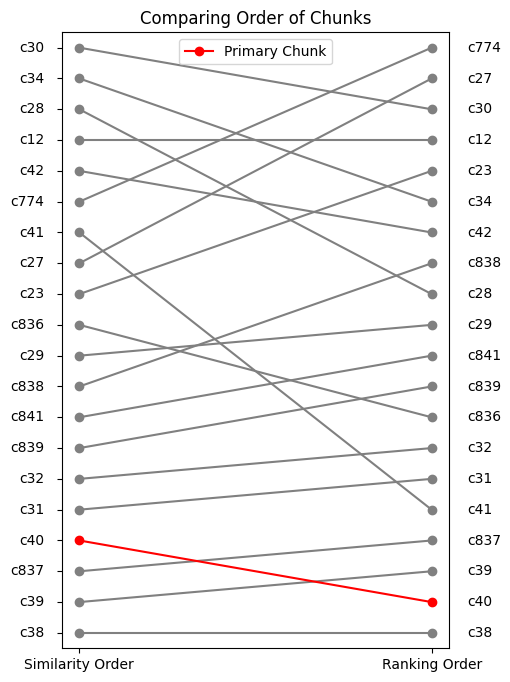

In [24]:
# Get order list of chunks by similarity and ranking
chunks_by_similarity = [vector_db[match[0]][0] for match in matches]
chunks_by_ranking = [record.id for record in rank_results.records]
n_chunks = len(chunks_by_similarity)

# Create the plot
fig, ax = plt.subplots(figsize=(5, 8))

for i in range(n_chunks):
    label = chunks_by_similarity[i]
    color = 'red' if label == 'c40' else 'gray'
    plot_label = 'Primary Chunk' if color == 'red' else None
    ax.plot([0, 1], [i, chunks_by_ranking.index(chunks_by_similarity[i])], marker='o', color=color, label=plot_label)
for i, label in enumerate(chunks_by_similarity):
    ax.text(-0.1, i, label, ha='right', va='center')
    ax.text(1.1, chunks_by_ranking.index(label), label, ha='left', va='center')

# Customize axes and labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Similarity Order', 'Ranking Order'])
ax.set_ylim(-0.5, n_chunks - 0.5)
ax.set_yticks(range(n_chunks))
#ax.set_yticklabels(chunks_by_similarity)
ax.set_yticklabels([])
ax.set_title('Comparing Order of Chunks')
ax.legend()

# Show the plot
plt.show()

# Example - Prompt With The Known Best Chunk: Correct Answer

> For a baseline use the known best chunk. In real-world situations this is not always possible but it makes a good baseline for the following examples that compare chunks retrieved from similarity and those filtered by ranking.

In [25]:
# construct prompt:
prompt = ''
prompt += f"Context {m+1}:\n{content_chunks['c40']}\n\n"
prompt += f'Answer the following question using the provided contexts:\n{question}'
print(prompt)

Context 20:
# Rule 2.03 to 2.05

## 2.03 The Bases

First, second and third bases shall be marked by white canvas or rubber-covered bags, securely attached to the ground as indicated in Diagram 2. The first and third base bags shall be entirely within the infield. The second base bag shall be centered on second base. The bags shall be 18 inches square, not less than three nor more than five inches thick, and filled with soft material.

Answer the following question using the provided contexts:
What are the dimensions of a base?


In [26]:
answer = llm.generate_content(prompt).text
print(answer)

According to the provided context, the bases are:

* **18 inches square:** This means each base is 18 inches long and 18 inches wide.
* **3 to 5 inches thick:** The bases can be between 3 and 5 inches thick. 



# Example - Prompt With Top 2 Chunks By Similarity: Wrong Answer

In [27]:
# construct prompt:
prompt = ''
for m, match in enumerate(chunks_by_similarity[0:2]):
    prompt += f"Context {m+1}:\n{content_chunks[match]}\n\n"
prompt += f'Answer the following question using the provided contexts:\n{question}'
print(prompt)

Context 1:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.

Context 2:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

It shall be set in the ground with the point at the intersection of the lines extending from home base to first base and to third base; with the 17-inch edge facing the pitcher's plate, and the two 12-inch edges coinciding with the first and third base lines. The top edges of home base shall be beveled and the base shall be fixed in the ground level with the ground surface. (See drawing D in Appendix 2.) 3

Answer the following question using the provided contexts:
What are the dimensions of a base?


In [28]:
answer = llm.generate_content(prompt).text
print(answer)

The dimensions of a base are:

* **One edge:** 17 inches long
* **Two adjacent sides:** 8 1/2 inches
* **Two remaining sides:** 12 inches 



# Example - Prompt with Top 2 Chunks By Ranking: Correct Answer

In [29]:
# construct prompt:
prompt = ''
for m, match in enumerate(chunks_by_ranking[0:2]):
    prompt += f"Context {m+1}:\n{content_chunks[match]}\n\n"
prompt += f'Answer the following question using the provided contexts:\n{question}'
print(prompt)

Context 1:
# 2.00-THE PLAYING FIELD

## 2.02 Home Base

Home base shall be marked by a five-sided slab of whitened rubber. It shall be a 17-inch square with two of the corners removed so that one edge is 17 inches long, two adjacent sides are 8\frac{1}{2} inches and the remaining two sides are 12 inches and set at an angle to make a point.

Context 2:
# Rule 2.03 to 2.05

## 2.03 The Bases

First, second and third bases shall be marked by white canvas or rubber-covered bags, securely attached to the ground as indicated in Diagram 2. The first and third base bags shall be entirely within the infield. The second base bag shall be centered on second base. The bags shall be 18 inches square, not less than three nor more than five inches thick, and filled with soft material.

Answer the following question using the provided contexts:
What are the dimensions of a base?
